### Telecom churn case study

### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

### Business goal

For many incumbent operators, retaining high profitable customers is the number one business goal.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

### Loading required libraries

In [1003]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter


pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
import warnings
warnings.filterwarnings('ignore')

In [666]:
telecom = pd.read_csv('telecom_churn_data.csv')
print(telecom.shape)
# telecom.head()

(99999, 226)


### Filter high value customers
We will first filter the high value customers and then will proceed with cleansing data.
The high value customers from the data set based on the recharge amount more than or equal to 70th percentile of the average recharge amount in the first two months 6th and 7th (the good phase)

In [667]:
# We have total recharge amount of all the calls and sms, but don't have the total recharge amount of the data.
# So lets introduce a new feature of total recharge amount for data by using av_rech_amt_data and total_rech_data

telecom['total_data_rech_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_data_rech_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_data_rech_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']
telecom['total_data_rech_amt_9'] = telecom['av_rech_amt_data_9'] * telecom['total_rech_data_9']

# drop the other columns
telecom.drop(['av_rech_amt_data_6', 'total_rech_data_6', 'av_rech_amt_data_7', 'total_rech_data_7', 'av_rech_amt_data_8', 'total_rech_data_8', 'av_rech_amt_data_9', 'total_rech_data_9'], axis=1, inplace=True)
# let's introduce another features to calculate to calculate 70th percentile of the average recharge amount in the first two months

telecom['total_data_calls_rech_amt_6'] = telecom.total_rech_amt_6.fillna(0) + telecom.total_data_rech_amt_6.fillna(0)
telecom['total_data_calls_rech_amt_7'] = telecom.total_rech_amt_7.fillna(0) + telecom.total_data_rech_amt_7.fillna(0)
avg_total_amt_6_7 = (telecom['total_data_calls_rech_amt_6'] + telecom['total_data_calls_rech_amt_7'])/2

percentile_70_avg_rech_amt = np.percentile(avg_total_amt_6_7, 70.0)
print("70th percentile of the average recharge amount: ", percentile_70_avg_rech_amt)

# drop the columns total_data_calls_rech_amt_6 and total_data_calls_rech_amt_7, which we have created for 70th percentile calculation.
telecom.drop(['total_data_calls_rech_amt_6', 'total_data_calls_rech_amt_7'], axis=1, inplace=True)

# filter out the high value customers
telecom_new = telecom[avg_total_amt_6_7 >= percentile_70_avg_rech_amt]
telecom_new.shape

70th percentile of the average recharge amount:  478.0


(30001, 222)

### Tag the churned customers

In [668]:
# tag the churned customers (churn=1, else 0) based on the fourth month as follows: 
# Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 

telecom_new['churn'] = np.where(telecom_new[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_new.churn.value_counts()

churn
0    27560
1     2441
Name: count, dtype: int64

### Handle missing values

In [669]:
# display the variable's count and percentage of null values
null_count = telecom_new.isna().sum()[telecom_new.isna().sum()>0]
null_percent = round((null_count/telecom_new.shape[0]) * 100, 2)
null_df = pd.DataFrame({'Null_Count' :null_count , "Null_Percentage" : null_percent})
null_df.sort_values(by='Null_Percentage', ascending=False)

,Null_Count,Null_Percentage
total_data_rech_amt_9,14781,49.27
date_of_last_rech_data_9,14781,49.27
fb_user_9,14781,49.27
max_rech_data_9,14781,49.27
count_rech_2g_9,14781,49.27
night_pck_user_9,14781,49.27
count_rech_3g_9,14781,49.27
arpu_3g_9,14781,49.27
arpu_2g_9,14781,49.27
arpu_2g_8,14048,46.83


In [670]:
# drop the variables having more than 40% null values
telecom_new.drop(null_df[null_df.Null_Percentage >40].index, axis=1, inplace=True)

# drop the variables that as same value for all customers, as it doesn't provide any information
telecom_new.drop(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9','mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'], axis=1, inplace=True)

# drop the date_of_last_rech as it doesn't add value to the data
telecom_new.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1, inplace=True)

We have tagged the churn customers, now we can drop the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [671]:
# dataset column names
col_names = list(telecom_new.columns)
# column names ending with _9
names_9 = [x for x in col_names if x.endswith('_9')]\
# drop the columns with _9
telecom_new.drop(names_9, axis=1, inplace=True)

Let's check the missing values again.

In [672]:
# display the variable's count and percentage of null values
null_count = telecom_new.isna().sum()[telecom_new.isna().sum()>0]
null_percent = round((null_count/telecom_new.shape[0]) * 100, 2)
null_df = pd.DataFrame({'Null_Count' :null_count , "Null_Percentage" : null_percent})
null_df.sort_values(by='Null_Percentage', ascending=False)

,Null_Count,Null_Percentage
ic_others_8,1174,3.91
loc_og_t2m_mou_8,1174,3.91
std_og_mou_8,1174,3.91
spl_og_mou_8,1174,3.91
std_og_t2f_mou_8,1174,3.91
og_others_8,1174,3.91
std_og_t2m_mou_8,1174,3.91
loc_ic_t2t_mou_8,1174,3.91
std_og_t2t_mou_8,1174,3.91
loc_ic_t2m_mou_8,1174,3.91


In [673]:
print(telecom_new.shape)
telecom_new.info()

(30001, 126)
<class 'pandas.core.frame.DataFrame'>
Index: 30001 entries, 0 to 99997
Columns: 126 entries, arpu_6 to churn
dtypes: float64(100), int32(1), int64(25)
memory usage: 29.0 MB


We see that the new dataset has only numerical values.

### Impute missing values

In [674]:
# define categorical and numerical columns
num_columns = telecom_new.select_dtypes(exclude='object').columns.to_list()

# function to impute null values
def fill_null_values(data, strategy='constant', fill_value=None):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy, fill_value=fill_value)
    return imputer.fit_transform(data)

# impute numerical features with its median on train dataset
telecom_new[num_columns] = fill_null_values(telecom_new[num_columns], strategy='median')


In [675]:
# check the missing values once again
telecom_new.columns[telecom_new.isna().sum()>0]

Index([], dtype='object')

In [676]:
telecom_new.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,197.385,214.816,213.803,88.06,86.885,0.00,229.635,227.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.58,25.78,0.00,80.24,81.685,0.00,0.11,0.21,0.00,0.0,0.0,0.00,129.35,132.73,0.00,3.36,3.30,0.00,18.185,17.75,0.00,0.00,0.00,0.00,50.795,50.035,0.00,0.0,0.00,0.00,0.31,0.81,0.00,0.0,0.0,0.0,0.00,0.00,0.00,26.03,26.66,0.16,86.76,88.37,4.13,2.01,2.16,1.15,138.63,141.79,5.44,0.48,0.55,0.00,5.34,5.54,0.00,0.00,0.00,0.00,11.98,12.74,0.00,0.00,0.00,5.44,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4.0,3.0,2.0,362.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,968.0,30.40,0.00,101.20,3.58,1.0
7,1069.180,1349.850,3171.480,57.84,54.680,52.29,453.430,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.380,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.890,31.76,49.14,6.66,20.08,16.68,60.860,75.140,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5.0,5.0,7.0,1580.0,790.0,3638.0,1580.0,790.0,1580.0,0.0,0.0,779.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,802.0,57.74,19.38,18.74,0.00,1.0
8,378.721,492.223,137.362,413.69,351.030,35.08,94.660,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.580,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.690,10.04,75.69,0.00,0.00,0.00,130.260,143.480,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19.0,21.0,14.0,437.0,601.0,120.0,90.0,154.0,30.0,50.0,0.0,10.0,0.00,356.00,0.03,0.00,750.95,11.94,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,21.03,910.65,122.16,0.00,0.0
21,514.453,597.753,637.760,102.41,132.110,85.14,757.930,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,

In [677]:
telecom_new.shape

(30001, 126)

In [678]:
# lets check the correlation amongst the features, drop the highly correlated ones
cor_matrix = telecom_new.corr()
cor_matrix.loc[:,:] = np.tril(cor_matrix, k=-1)
cor_matrix = cor_matrix.stack()
cor_matrix[(cor_matrix > 0.60) | (cor_matrix < -0.60)].sort_values()

roam_og_mou_8       roam_og_mou_7       0.601079
monthly_3g_6        vol_3g_mb_6         0.601308
total_ic_mou_7      loc_ic_t2t_mou_7    0.601398
std_ic_mou_6        std_ic_t2m_mou_7    0.603025
total_rech_amt_8    arpu_6              0.603673
total_ic_mou_8      loc_ic_t2t_mou_8    0.604791
loc_og_mou_6        loc_og_t2t_mou_7    0.605588
std_ic_mou_7        std_ic_t2m_mou_8    0.605905
roam_ic_mou_8       roam_ic_mou_7       0.606110
aug_vbc_3g          vol_3g_mb_8         0.607689
std_ic_t2m_mou_8    std_ic_t2m_mou_6    0.607808
std_og_t2m_mou_7    offnet_mou_6        0.608605
std_og_mou_7        std_og_t2t_mou_8    0.608652
total_rech_amt_8    total_rech_amt_6    0.609306
std_og_t2t_mou_8    std_og_t2t_mou_6    0.609693
total_rech_amt_6    arpu_8              0.610687
monthly_3g_7        monthly_3g_6        0.611599
total_og_mou_6      std_og_t2t_mou_6    0.611667
loc_ic_mou_6        loc_ic_t2m_mou_8    0.611806
total_ic_mou_6      loc_ic_t2t_mou_6    0.611940
last_day_rch_amt_7  

In [679]:
# drop the columns with high correlation
high_cor_col = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8',
                'onnet_mou_7', 'std_og_mou_7', 'std_og_t2f_mou_7', 'offnet_mou_7', 'arpu_7', 'isd_og_mou_6', 'loc_og_mou_6', 'loc_ic_mou_6','loc_ic_mou_7',
                'isd_og_mou_7', 'loc_og_mou_7', 'total_rech_num_7', 'std_ic_t2t_mou_6', 'std_ic_mou_6', 'isd_ic_mou_6', 'std_ic_mou_7',
                'isd_ic_mou_7', 'sachet_2g_7', 'std_ic_t2f_mou_6', 'ic_others_7', 'std_ic_t2t_mou_7','max_rech_amt_8', 'std_ic_t2f_mou_7']
                 
telecom_new.drop(high_cor_col, axis=1, inplace=True)
telecom_new.shape

(30001, 64)

#### Convert age on network to years

In [681]:
# convert age on network to years instead of days
telecom_new['aon'] = round(telecom_new['aon']/365, 2)

In [682]:
telecom_new.head()
# telecom_new.columns

,arpu_6,arpu_8,onnet_mou_6,onnet_mou_8,offnet_mou_6,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_8,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_8,ic_others_6,ic_others_8,total_rech_num_6,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,197.385,213.803,88.06,0.00,229.635,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,50.795,0.00,0.00,0.31,0.81,0.00,0.0,0.0,0.0,5.44,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,4.0,2.0,252.0,252.0,252.0,252.0,252.0,30.13,1.32,5.75,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.65,30.40,0.00,101.20,3.58,1.0
7,1069.180,3171.480,57.84,52.29,453.430,325.91,16.23,33.49,31.64,23.74,12.59,38.06,0.0,0.0,0.00,255.79,6.66,16.68,60.860,77.84,10.01,4.50,0.00,6.50,0.0,0.0,0.0,188.04,30.39,22.21,193.94,0.21,0.0,0.0,31.59,15.74,15.14,5.0,7.0,1580.0,790.0,0.0,0.0,779.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.20,57.74,19.38,18.74,0.00,1.0
8,378.721,137.362,413.69,35.08,94.660,136.48,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,7.15,63.04,0.00,0.00,130.260,98.28,0.00,0.00,0.00,10.23,0.0,0.0,0.0,15.79,0.10,0.00,0.75,0.00,0.0,0.0,0.00,0.00,0.00,19.0,14.0,90.0,154.0,50.0,0.0,10.0,0.00,356.00,0.03,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.86,21.03,910.65,122.16,0.00,0.0
21,514.453,637.760,102.41,85.14,757.930,983.39,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,129.74,0.00,0.00,763.290,938.79,0.00,0.00,0.00,0.00,0.0,0.0,0.0,159.11,0.18,0.00,101.93,0.00,0.0,0.0,0.00,0.00,0.00,22.0,27.0,50.0,50.0,30.0,20.0,50.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.97,0.00,0.00,0.00,0.00,0.0
23,74.350,366.966,48.96,33.58,85.410,205.89,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,17.71,182.14,0.00,0.00,2.360,39.61,0.00,0.10,0.00,17.71,0.0,0.0,0.0,224.21,13.38,0.00,57.29,0.00,0.0,0.0,3.74,0.00,13.06,3.0,4.0,0.0,179.0,0.0,179.0,0.0,0.00,0.48,0.01,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.65,40.45,51.86,0.00,0.00,0.0


### Data visualization

#### Churn rate

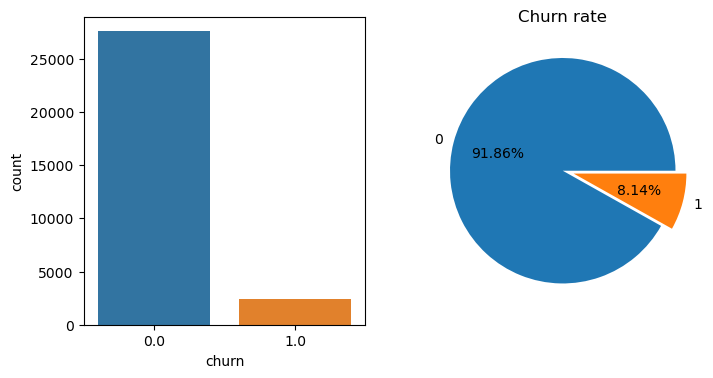

In [683]:
plt.figure(figsize=(8,4))
plt.title('Churn rate')
plt.subplot(1,2,1)
sns.countplot(x = 'churn', data=telecom_new)
plt.subplot(1,2,2)
plt.pie(telecom_new.churn.value_counts(), labels = [0, 1],explode=[0,0.1], autopct = "%.2f%%")
plt.title('Churn rate')
plt.show()

 #### Compared to non-churn, the churn rate is much lower. We see the data set has high class imbalance.

#### onnet_mou_and offnet_mou

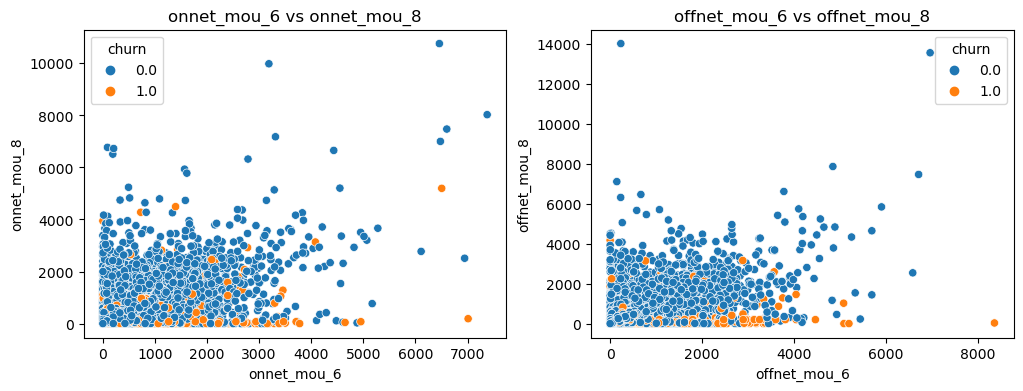

In [684]:
# onnet_mou_6 vs onnet_mou_8
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('onnet_mou_6 vs onnet_mou_8')
sns.scatterplot(x='onnet_mou_6', y='onnet_mou_8', hue= 'churn', data=telecom_new)
plt.subplot(1,2,2)
plt.title('offnet_mou_6 vs offnet_mou_8')
sns.scatterplot(x='offnet_mou_6', y='offnet_mou_8', hue= 'churn', data=telecom_new)
plt.show()

#### Most of the customers who are churned have used the calls with in the same network much in 6th month compared to 8th month
#### Most of the customers who are churned have used the calls outside the network much in 6th month compared to 8th month
#### This implies that onnet and offnet usage was high in 6th month compared to 8th month

#### Churn Vs Age on network

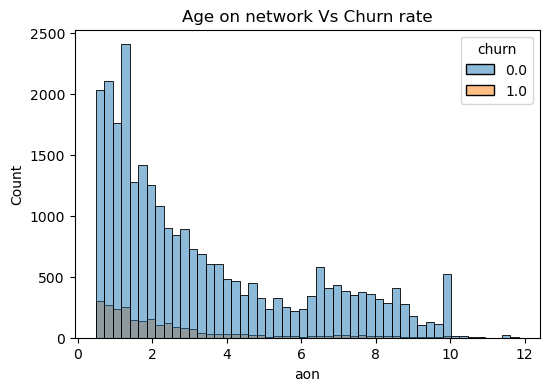

In [685]:
plt.figure(figsize=(6,4))
plt.title('Age on network Vs Churn rate')
sns.histplot(x='aon', hue='churn', data=telecom_new)
plt.show()

#### From the above graph, we notice that churn rate is high with customers whose tenure is less than 3 years. This implies that the long term tenured customers contiued to use the service. 

#### total_rech_num_6 Vs total_rech_num_8

<Figure size 600x400 with 0 Axes>

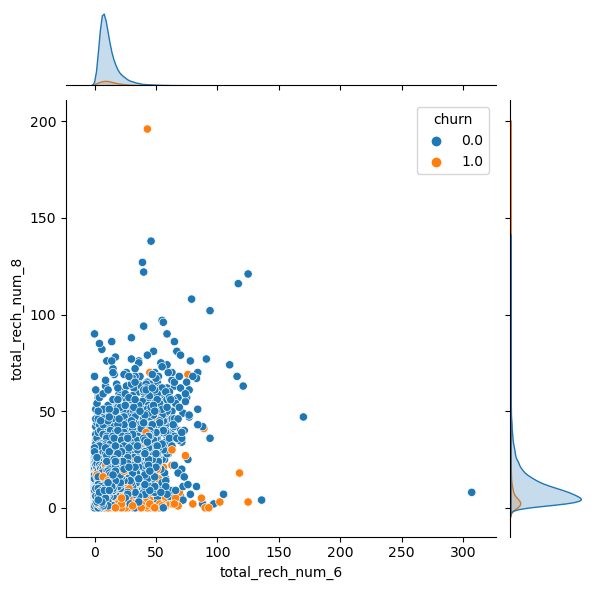

In [686]:
plt.figure(figsize=(6,4))
sns.jointplot(x='total_rech_num_6', y='total_rech_num_8', hue='churn', kind='scatter', data=telecom_new)
plt.show()

#### Maximum recharge amount in good phase

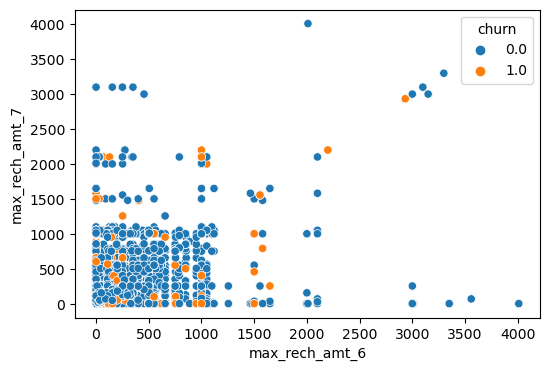

In [687]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='max_rech_amt_6', y='max_rech_amt_7', hue='churn', data=telecom_new)
plt.show()

#### Most of the churned customers seems to have recharged good amount in 7th month.

#### Local outgoing usage

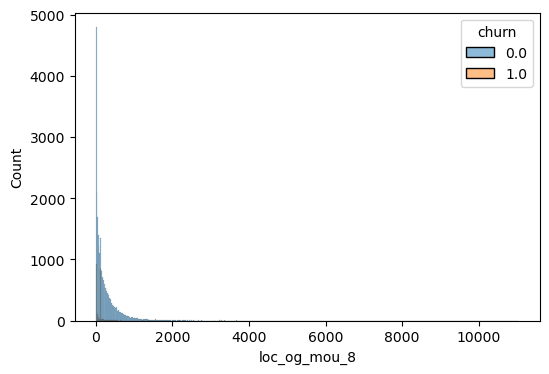

In [688]:
plt.figure(figsize=(6,4))
sns.histplot(x='loc_og_mou_8', hue='churn', data=telecom_new)
plt.show()

#### It implies that churned customers have less usage of outgoing calls during action phase

#### Volume of internet usage during good and action phases

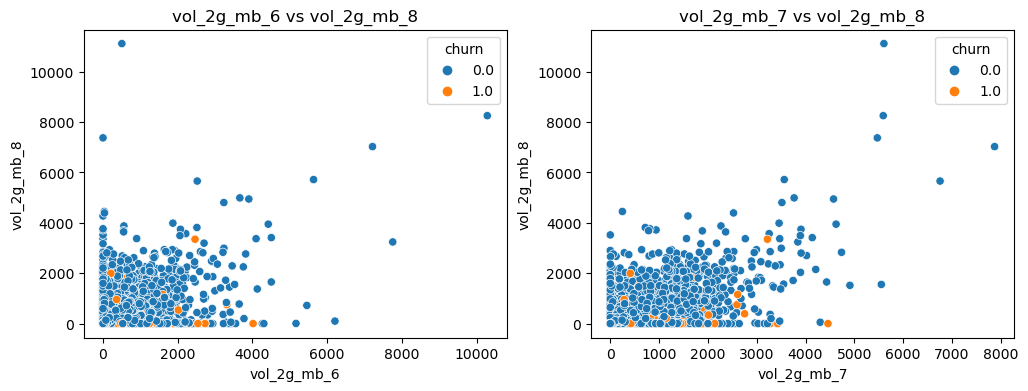

In [689]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('vol_2g_mb_6 vs vol_2g_mb_8')
sns.scatterplot(x='vol_2g_mb_6', y='vol_2g_mb_8', hue= 'churn', data=telecom_new)
plt.subplot(1,2,2)
plt.title('vol_2g_mb_7 vs vol_2g_mb_8')
sns.scatterplot(x='vol_2g_mb_7', y='vol_2g_mb_8', hue= 'churn', data=telecom_new)
plt.show()

#### Above graph shows that most of the churned customers have limited the internet usage during action phase.

#### Montly usage of 3g during good and action phases

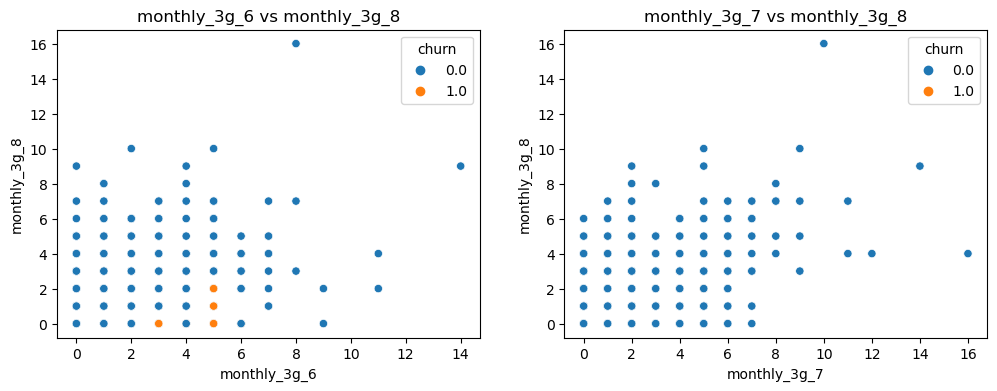

In [690]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('monthly_3g_6 vs monthly_3g_8')
sns.scatterplot(x='monthly_3g_6', y='monthly_3g_8', hue= 'churn', data=telecom_new)
plt.subplot(1,2,2)
plt.title('monthly_3g_7 vs monthly_3g_8')
sns.scatterplot(x='monthly_3g_7', y='monthly_3g_8', hue= 'churn', data=telecom_new)
plt.show()

#### It infers that 3g usage during action phase is lower compared to good phase

#### Average revenue per user during good and action phase

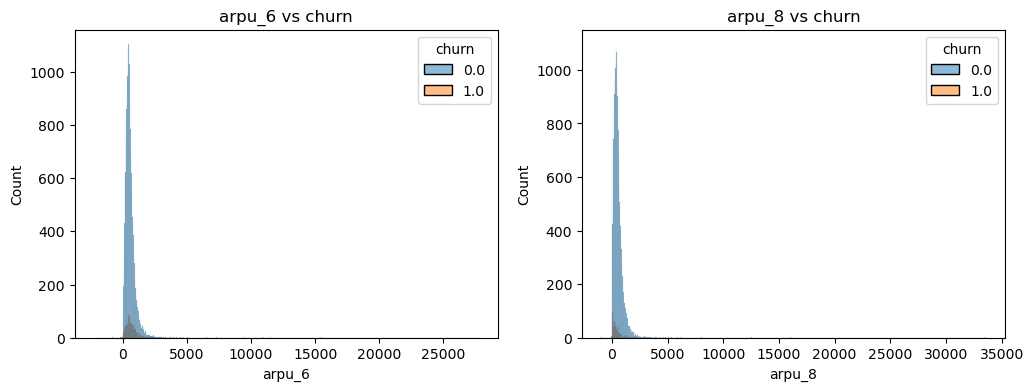

In [691]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('arpu_6 vs churn')
sns.histplot(x='arpu_6', hue='churn', data=telecom_new)
plt.subplot(1,2,2)
plt.title('arpu_8 vs churn')
sns.histplot(x='arpu_8', hue='churn', data=telecom_new)
plt.show()


#### It implies that the average revenue per user declined during the action phase.

### Separating X and y variables

In [692]:
X = telecom_new.drop('churn', axis=1)
y = telecom_new['churn']

### Feature scaling

In [693]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Split the dataset into train and test sets

In [694]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

In [695]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 63), (9001, 63), (21000,), (9001,))

In [696]:
y_train.value_counts(), y_test.value_counts()

(churn
 0.0    19291
 1.0     1709
 Name: count, dtype: int64,
 churn
 0.0    8269
 1.0     732
 Name: count, dtype: int64)

### Handling imbalance class using SMOTE

In [697]:
smt = SMOTE(random_state=42)
X_smt,y_smt = smt.fit_resample(X_train,y_train)

In [698]:
X_smt.shape, X_test.shape, y_smt.shape, y_test.shape

((38582, 63), (9001, 63), (38582,), (9001,))

In [699]:
print(sorted(Counter(y_smt).items()))

[(0.0, 19291), (1.0, 19291)]


### PCA on data

In [700]:
pca = PCA(random_state=42)
pca.fit(X_smt)

PCA(random_state=42)

In [701]:
# PCA components
pca.components_

array([[ 1.36228231e-01,  1.16200850e-01,  5.16619923e-02, ...,
         2.14370492e-03,  8.64516078e-03,  1.72641238e-03],
       [ 1.89999639e-01,  4.52405645e-02,  3.21481975e-01, ...,
        -1.67871283e-01, -1.67106534e-01, -3.13691085e-02],
       [ 2.32884175e-01,  2.60988595e-01,  9.59991832e-02, ...,
         1.38730500e-01,  1.20414462e-01,  3.41653708e-02],
       ...,
       [ 1.17659220e-01, -7.88219370e-01,  1.20757219e-01, ...,
         1.45118132e-02,  9.46665207e-03,  2.07159853e-02],
       [ 1.25415131e-01, -2.06057838e-01, -4.79861831e-01, ...,
         4.16309311e-03, -8.35457595e-03,  2.71792623e-03],
       [ 8.57322103e-03, -3.23147032e-02, -4.66799743e-03, ...,
        -1.18950666e-03,  1.27839376e-03,  2.64219714e-04]])

In [702]:
# explained variance ratio of each component
pca.explained_variance_ratio_

array([1.09086553e-01, 7.90111059e-02, 6.81608506e-02, 5.36515840e-02,
       4.62518918e-02, 3.76354394e-02, 3.46059439e-02, 3.18693225e-02,
       2.93367609e-02, 2.87908946e-02, 2.61038081e-02, 2.46171206e-02,
       2.20109066e-02, 2.07283568e-02, 2.04828468e-02, 1.97421048e-02,
       1.94001197e-02, 1.61480676e-02, 1.52868021e-02, 1.45776488e-02,
       1.39320247e-02, 1.33997368e-02, 1.23022840e-02, 1.14874141e-02,
       1.14424277e-02, 1.11751411e-02, 1.08033045e-02, 1.05023937e-02,
       1.01471667e-02, 9.61381158e-03, 9.48868518e-03, 9.11644967e-03,
       8.95419280e-03, 8.71210709e-03, 8.34540323e-03, 8.16767244e-03,
       7.50123861e-03, 7.26224786e-03, 6.59332289e-03, 6.47357448e-03,
       5.97182421e-03, 5.89771478e-03, 5.74209981e-03, 5.53461652e-03,
       5.11325340e-03, 4.78600947e-03, 4.71980290e-03, 4.60760077e-03,
       4.41697276e-03, 4.13405496e-03, 4.00901673e-03, 3.91601973e-03,
       3.84653418e-03, 3.72862683e-03, 3.56663854e-03, 3.51572360e-03,
      

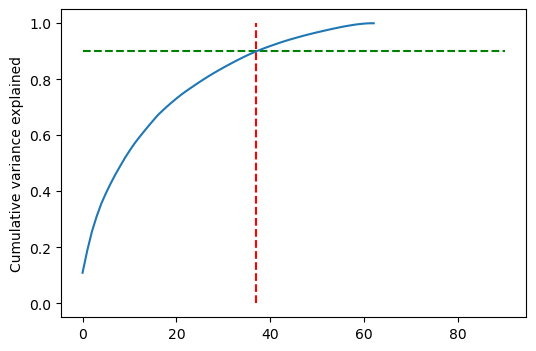

In [703]:
# Making a scree plot
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=(6,4))
plt.vlines(x=37, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=90, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

#### As we observe from the graph, 90% of the variation in the data is explained by 37 principal components.
#### Hence, going forward we will consider 37 principal components to perform PCA

In [704]:
# Perform PCA with 37 components
pca_final = IncrementalPCA(n_components=37)
X_tr_smt_pca_37 = pca_final.fit_transform(X_smt)
X_tr_smt_pca_37.shape

(38582, 37)

In [705]:
corrmat = np.corrcoef(X_tr_smt_pca_37.transpose())
corrmat.shape

(37, 37)

*Apply transformation on test*

In [706]:
X_test_smt_pca_37 = pca_final.transform(X_test)
X_test_smt_pca_37.shape

(9001, 37)

### Helper function for model building on PCA components

In [707]:
training_score = []
testing_score = []

def model_prediction(model):
    model.fit(X_tr_smt_pca_37,y_smt)
    x_train_pred = model.predict(X_tr_smt_pca_37)
    x_test_pred = model.predict(X_test_smt_pca_37)
    a = accuracy_score(y_smt,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of model on Training Data is:",a)
    print(f"Accuracy_Score of model on Testing Data is:",b)
    print(f"ROC AUC score of model on Training data:",roc_auc_score(y_smt,x_train_pred))
    print(f"ROC AUC score of model on Testing data:",roc_auc_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of model is:",precision_score(y_test,x_test_pred))
    print(f"Recall Score of model is:",recall_score(y_test,x_test_pred))
    print(f"F1 Score of model is:",f1_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(classification_report(y_test,x_test_pred))
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    print(cm)

### We will apply different algorithms on pca components with minimal parameters and later we will perform hyper parameter tuning on the models which perform better.

### Using Decision tree

In [708]:
dt_pca = model_prediction(DecisionTreeClassifier(max_depth=15, random_state=100))

Accuracy_Score of model on Training Data is: 96.44393758747603
Accuracy_Score of model on Testing Data is: 82.51305410509944
ROC AUC score of model on Training data: 0.9644393758747603
ROC AUC score of model on Testing data: 0.7242731923234252

------------------------------------------------------------------------
Precision Score of model is: 0.25608342989571264
Recall Score of model is: 0.6038251366120219
F1 Score of model is: 0.3596419853539463

------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      8269
         1.0       0.26      0.60      0.36       732

    accuracy                           0.83      9001
   macro avg       0.61      0.72      0.63      9001
weighted avg       0.90      0.83      0.85      9001

Confusion Matrix of DecisionTreeClassifier(max_depth=15, random_state=100) model is:
[[6985 1284]
 [ 290  442]]


### Using RandomForest

In [709]:
ran_pca = model_prediction(RandomForestClassifier(random_state=42, n_jobs=-1))

Accuracy_Score of model on Training Data is: 100.0
Accuracy_Score of model on Testing Data is: 90.34551716475947
ROC AUC score of model on Training data: 1.0
ROC AUC score of model on Testing data: 0.7351500303655697

------------------------------------------------------------------------
Precision Score of model is: 0.42546245919477693
Recall Score of model is: 0.5341530054644809
F1 Score of model is: 0.4736523319200484

------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      8269
         1.0       0.43      0.53      0.47       732

    accuracy                           0.90      9001
   macro avg       0.69      0.74      0.71      9001
weighted avg       0.91      0.90      0.91      9001

Confusion Matrix of RandomForestClassifier(n_jobs=-1, random_state=42) model is:
[[7741  528]
 [ 341  391]]


### Using Ada boost classifier

In [710]:
model_prediction(AdaBoostClassifier(random_state=42))

Accuracy_Score of model on Training Data is: 82.64994038670883
Accuracy_Score of model on Testing Data is: 82.10198866792578
ROC AUC score of model on Training data: 0.8264994038670883
ROC AUC score of model on Testing data: 0.7967471172533931

------------------------------------------------------------------------
Precision Score of model is: 0.28057913130304546
Recall Score of model is: 0.76775956284153
F1 Score of model is: 0.4109689213893968

------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.89      8269
         1.0       0.28      0.77      0.41       732

    accuracy                           0.82      9001
   macro avg       0.63      0.80      0.65      9001
weighted avg       0.92      0.82      0.86      9001

Confusion Matrix of AdaBoostClassifier(random_state=42) model is:
[[6828 1441]
 [ 170  562]]


### Using Gradient boosting classifier

In [711]:
model_prediction(GradientBoostingClassifier(random_state=42))

Accuracy_Score of model on Training Data is: 86.03234669016639
Accuracy_Score of model on Testing Data is: 84.50172203088546
ROC AUC score of model on Training data: 0.8603234669016641
ROC AUC score of model on Testing data: 0.8017142338855968

------------------------------------------------------------------------
Precision Score of model is: 0.31175468483816016
Recall Score of model is: 0.75
F1 Score of model is: 0.44043321299638993

------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      8269
         1.0       0.31      0.75      0.44       732

    accuracy                           0.85      9001
   macro avg       0.64      0.80      0.68      9001
weighted avg       0.92      0.85      0.87      9001

Confusion Matrix of GradientBoostingClassifier(random_state=42) model is:
[[7057 1212]
 [ 183  549]]


### Using XG Boost

In [712]:
model_prediction(XGBClassifier(random_state=42))

Accuracy_Score of model on Training Data is: 98.60038359856928
Accuracy_Score of model on Testing Data is: 89.42339740028886
ROC AUC score of model on Training data: 0.9860038359856929
ROC AUC score of model on Testing data: 0.7730902237403906

------------------------------------------------------------------------
Precision Score of model is: 0.40350877192982454
Recall Score of model is: 0.6284153005464481
F1 Score of model is: 0.49145299145299143

------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      8269
         1.0       0.40      0.63      0.49       732

    accuracy                           0.89      9001
   macro avg       0.68      0.77      0.72      9001
weighted avg       0.92      0.89      0.90      9001

Confusion Matrix of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
   

### Displaying all model performances

In [713]:
models = ["Decision Tree","Random Forest","Ada Boost",
          "Gradient Boost","XGBoost"]
df_perf = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})

In [714]:
df_perf

,Algorithms,Training Score,Testing Score
0,Decision Tree,96.443938,82.513054
1,Random Forest,100.000000,90.345517
2,Ada Boost,82.649940,82.101989
3,Gradient Boost,86.032347,84.501722
4,XGBoost,98.600384,89.423397


<Figure size 400x400 with 0 Axes>

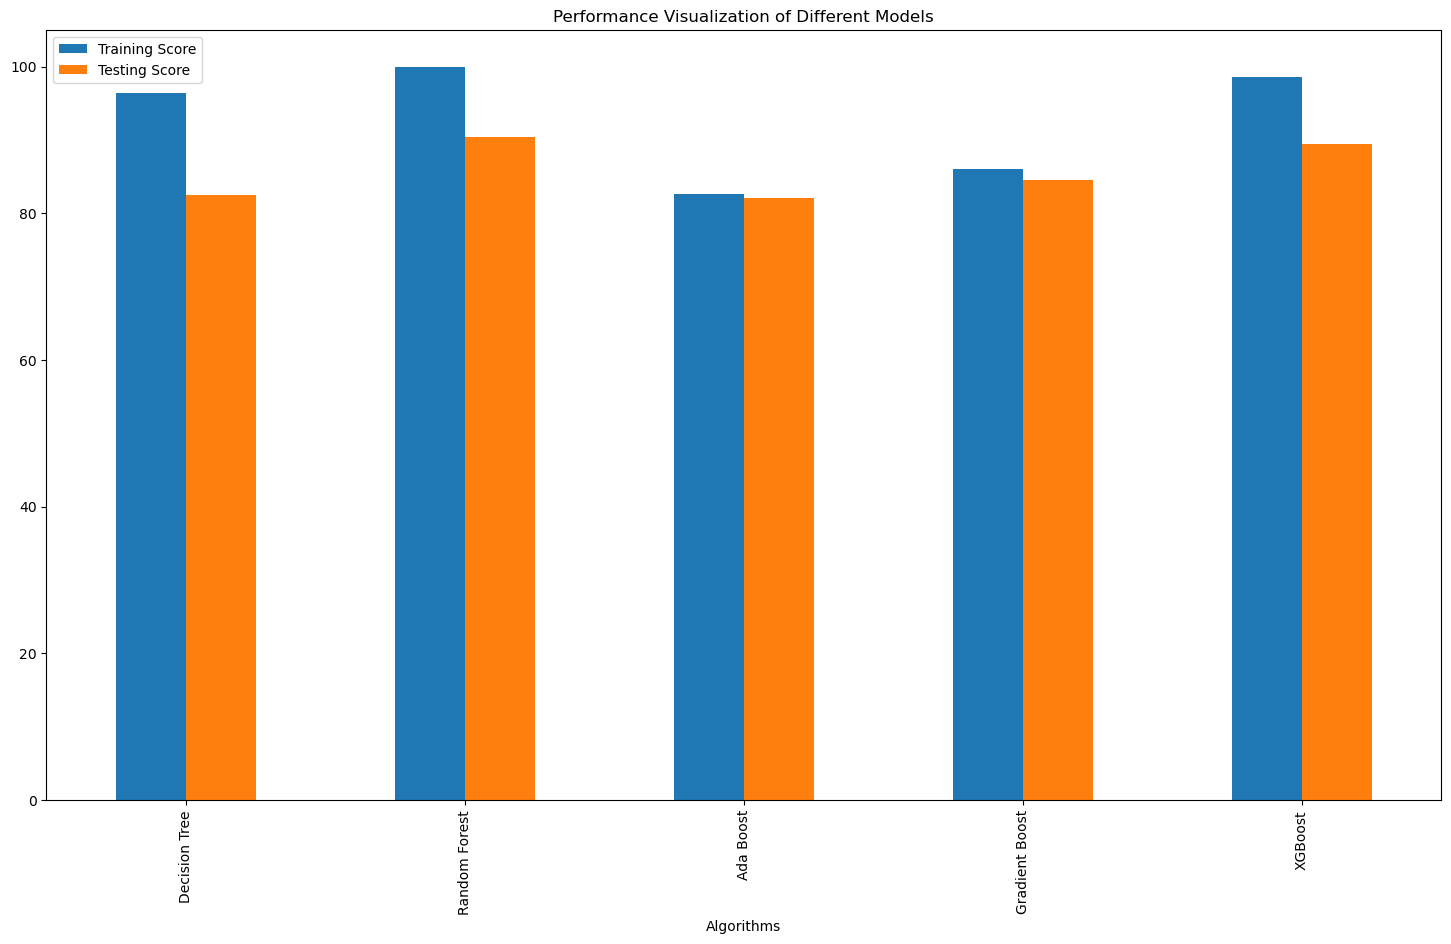

In [1147]:
plt.figure(figsize=(4,4))
df_perf.plot(x="Algorithms",y=["Training Score","Testing Score"], figsize=(18,10),kind="bar",
        title="Performance Visualization of Different Models")
plt.show()

#### As per the problem statement, it is important to identify the churners than the non-churners accurately. Hence we will consider recall metrics along with training and testing score.

*We will perform hyper tunning on these models for further improvement of the score.*

### Hyper parameter tuning on XGBoost

In [716]:
# params = {"n_estimators":[600,800,1000]}
params = {
        'n_estimators' : [50, 100, 150],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25], 
        'max_depth': [5, 10, 12]
        }
xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [717]:
grid_search_xgb.fit(X_tr_smt_pca_37,y_smt)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
CPU times: total: 4min 7s
Wall time: 43min 56s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.25],
                         'max_depth': [5, 10, 12],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [718]:
grid_search_xgb.best_score_

0.9574413689932044

In [719]:
xgb_best_params = grid_search_xgb.best_params_
xgb_best_params

{'learning_rate': 0.25, 'max_depth': 12, 'n_estimators': 150}

#### Building XGBoost model using best parameters

In [720]:
xgb_best = XGBClassifier(n_estimators=1000, max_depth=12, objective = 'binary:logistic', random_state=42, n_jobs=-1)
# xgb_best = XGBClassifier(n_estimators=150, max_depth=12, learning_rate = 0.25, objective = 'binary:logistic', random_state=42, n_jobs=-1)
xgb_best.fit(X_tr_smt_pca_37,y_smt)

CPU times: total: 15min 11s
Wall time: 2min 8s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [721]:
x_test_xgb_pred = xgb_best.predict(X_test_smt_pca_37)
accuracy_score(y_test,x_test_xgb_pred)

0.913676258193534

In [722]:
recall_score(y_test,x_test_xgb_pred)

0.5778688524590164

In [723]:
precision_score(y_test,x_test_xgb_pred)

0.47474747474747475

##### We noticed that XGBoost yields 91% accuracy with 57.7% recall score.

### Hyper parameter tunning on RandomForest

In [858]:
ran_for_model = RandomForestClassifier(random_state=10)
ran_params = {'n_estimators': [30,50,70,100],
               'max_depth': [5,7,8],
               'min_samples_split':[20,30,50]}

In [859]:
grid_search_ran = GridSearchCV(ran_for_model, ran_params, cv=5, n_jobs=-1)

In [860]:
grid_search_ran.fit(X_tr_smt_pca_37,y_smt)

CPU times: total: 23.1 s
Wall time: 15min 17s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 8],
                         'min_samples_split': [20, 30, 50],
                         'n_estimators': [30, 50, 70, 100]})

In [861]:
grid_search_ran.best_score_

0.8616712726435336

In [862]:
best_params_ran = grid_search_ran.best_params_
best_params_ran

{'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 50}

#### Building Random Forest model using best parameters

In [873]:
ran_best = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_split=20, random_state=42, n_jobs=-1)
# ran_best = RandomForestClassifier(n_estimators=150, max_depth=12,random_state=42) 30, 11, 10 - 50 10 8 - 50 8 8 - 100 8 50
ran_best.fit(X_tr_smt_pca_37,y_smt)

CPU times: total: 37.3 s
Wall time: 5.37 s


RandomForestClassifier(max_depth=8, min_samples_split=20, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [874]:
x_test_ran_pred = ran_best.predict(X_test_smt_pca_37)
accuracy_score(y_test,x_test_ran_pred)

0.854127319186757

In [875]:
recall_score(y_test,x_test_ran_pred)

0.7117486338797814

In [876]:
precision_score(y_test,x_test_ran_pred)

0.32101047443006775

In [877]:
roc_auc_score(y_test,x_test_ran_pred)

0.7892398992352105

##### We noticed that Random Forest yields 85% accuracy with 71% recall score.

### Hyper parameter tuning on Ada Boost

In [922]:
ada_params = {
        'n_estimators' : [100, 500, 1000],
        'learning_rate' : [ 0.02, 0.1, 0.2]
        }
ada = AdaBoostClassifier(random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [923]:
grid_search_ada = GridSearchCV(ada, ada_params, cv=4, n_jobs=-1)

In [924]:
grid_search_ada.fit(X_tr_smt_pca_37,y_smt)

CPU times: total: 10min 11s
Wall time: 50min 27s


GridSearchCV(cv=4, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.1, 0.2],
                         'n_estimators': [100, 500, 1000]})

In [925]:
grid_search_ada.best_score_

0.8456535111747999

In [926]:
best_params_ada = grid_search_ada.best_params_
best_params_ada

{'learning_rate': 0.2, 'n_estimators': 1000}

#### Building Ada Boost model using best parameters

In [908]:
ada_best = AdaBoostClassifier(n_estimators=1000, learning_rate=0.2, random_state=42)
ada_best.fit(X_tr_smt_pca_37,y_smt)

CPU times: total: 10min 10s
Wall time: 10min 23s


AdaBoostClassifier(learning_rate=0.2, n_estimators=1000, random_state=42)

In [917]:
x_test_ada_pred = ada_best.predict(X_test_smt_pca_37)
accuracy_score(y_test,x_test_ada_pred)

0.8361293189645594

In [919]:
recall_score(y_test,x_test_ada_pred)

0.7663934426229508

In [920]:
precision_score(y_test,x_test_ada_pred)

0.30080428954423594

In [921]:
roc_auc_score(y_test,x_test_ada_pred)

0.8043480092543948

##### We noticed that Ada Boost yields 83.6% accuracy with 76.6% recall score.

### Logistic Regression

In [1053]:
# Separating X and y variables
X = telecom_new.drop('churn', axis=1)
y = telecom_new['churn']

In [1054]:
# Apply scaling on X dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1055]:
X = pd.DataFrame(X)
X.columns = telecom_new.drop('churn', axis=1).columns

In [1056]:
# Splitting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

In [1057]:
len(X_train), len(y_train)

(21000, 21000)

### Feature selection using RFE

In [1058]:
# Creating logistic regression object
logreg = LogisticRegression()

# Handling imbalance using smote
smt = SMOTE(random_state=42)
X_smt,y_smt = smt.fit_resample(X_train,y_train)

# running RFE with 15 variables
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_smt, y_smt)

In [1059]:
# features selected by RFE
col = X_smt.columns[rfe.support_]
col

Index(['arpu_6', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8',
       'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8',
       'spl_og_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g'],
      dtype='object')

#### Creating helper functions to build model, check VIF and retrieve metrics

In [1123]:
# function to build model using stats model
def build_model(X, y):
    X_train_sm = sm.add_constant(X)
    logm = sm.GLM(y, X_train_sm, family=sm.families.Binomial()).fit()
    return logm, X_train_sm

# function to create a dataframe that will contain the names of all the feature variables and their respective VIFs
def get_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

# function to get few accuracy, precision, recall and f1 score
def get_metrics(actual, predict, cutoff):
    accuracy = accuracy_score(actual, predict[cutoff])
    precision = precision_score(actual, predict[cutoff])
    recall = recall_score(actual, predict[cutoff])
    print(f"accuracy: {round(accuracy, 2)}")
    print(f"precision: {round(precision, 2)}")
    print(f"recall: {round(recall, 2)}")

##### Logistic regression model1

In [1062]:
# Build the model1 using stats model
logm1, X_train_sm = build_model(X_smt[col], y_smt)
logm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38582
Model:                            GLM   Df Residuals:                    38561
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14209.
Date:                Mon, 05 Feb 2024   Deviance:                       28419.
Time:                        23:04:29   Pearson chi2:                 9.28e+09
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4778
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9520      0.032    -61.269      0.000      -2.014      -1.890
arpu_6                 0.4236      0.021     20.235      0.000       0.383       0.465
onnet_mou_8           14.7196      0.321     45.824      0.000      14.090      15.349
offnet_mou_8          15.3339      0.335     45.723      0.000      14.677      15.991
roam_og_mou_8         -3.1121      0.074    -42.078      0.000      -3.257      -2.967
loc_og_mou_8         -12.3435      0.257    -47.966      0.000     -12.848     -11.839
std_og_t2f_mou_8      -0.3313      0.055     -6.026      0.000      -0.439      -0.224
std_og_mou_8         -19.7115      0.426    -46.224      0.000     -20.547     -18.876
isd_og_mou_8          -1.4848      0.036    -40.745      0.000      -1.556      -1.413
spl_og_mou_8          -0.6263      0.024    -26.377      0.000      -0.673      -0.580
loc_ic_mou_8          -1.1110      0.051    -21.694      0.000      -1.211      -1.011
spl_ic_mou_8          -0.3424      0.026    -13.087      0.000      -0.394      -0.291
total_rech_num_8      -0.3925      0.025    -15.507      0.000      -0.442      -0.343
last_day_rch_amt_8    -0.5412      0.026    -21.196      0.000      -0.591      -0.491
vol_2g_mb_8           -0.2248      0.033     -6.719      0.000      -0.290      -0.159
monthly_2g_8          -0.5849      0.030    -19.565      0.000      -0.643      -0.526
sachet_2g_8           -0.7115      0.033    -21.289      0.000      -0.777      -0.646
monthly_3g_8          -0.8021      0.034    -23.277      0.000      -0.870      -0.735
aon                   -0.2941      0.019    -15.631      0.000      -0.331      -0.257
aug_vbc_3g            -0.2106      0.034     -6.136      0.000      -0.278      -0.143
sep_vbc_3g            -1.2664      0.124    -10.228      0.000      -1.509      -1.024
======================================================================================
"""

In [1063]:
# get VIF
get_vif(X_smt[col])

,Features,VIF
6,std_og_mou_8,191.19
2,offnet_mou_8,112.53
1,onnet_mou_8,108.97
4,loc_og_mou_8,57.36
3,roam_og_mou_8,10.40
11,total_rech_num_8,1.95
7,isd_og_mou_8,1.78
9,loc_ic_mou_8,1.53
18,aug_vbc_3g,1.49
16,monthly_3g_8,1.41


In [1064]:
# drop the column std_og_mou_8 as it has high correlation with other features
col = col.drop('std_og_mou_8',1)
col

Index(['arpu_6', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8',
       'loc_og_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'loc_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g'],
      dtype='object')

#### Logistic regression model2

In [1065]:
# Rerun to build model2 using stats model
logm2, X_train_sm = build_model(X_smt[col], y_smt)
logm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38582
Model:                            GLM   Df Residuals:                    38562
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16180.
Date:                Mon, 05 Feb 2024   Deviance:                       32360.
Time:                        23:04:46   Pearson chi2:                 3.44e+12
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4216
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8811      0.031    -59.968      0.000      -1.943      -1.820
arpu_6                 0.4111      0.019     21.224      0.000       0.373       0.449
onnet_mou_8           -0.0872      0.020     -4.470      0.000      -0.125      -0.049
offnet_mou_8          -0.0848      0.022     -3.890      0.000      -0.128      -0.042
roam_og_mou_8          0.2528      0.014     18.548      0.000       0.226       0.279
loc_og_mou_8          -0.6683      0.043    -15.480      0.000      -0.753      -0.584
std_og_t2f_mou_8      -0.5511      0.065     -8.529      0.000      -0.678      -0.424
isd_og_mou_8          -0.0298      0.016     -1.837      0.066      -0.062       0.002
spl_og_mou_8          -0.1547      0.026     -5.943      0.000      -0.206      -0.104
loc_ic_mou_8          -0.8042      0.043    -18.786      0.000      -0.888      -0.720
spl_ic_mou_8          -0.4414      0.028    -15.924      0.000      -0.496      -0.387
total_rech_num_8      -0.9421      0.027    -34.525      0.000      -0.996      -0.889
last_day_rch_amt_8    -0.7352      0.026    -28.156      0.000      -0.786      -0.684
vol_2g_mb_8           -0.3294      0.035     -9.431      0.000      -0.398      -0.261
monthly_2g_8          -0.6204      0.029    -21.646      0.000      -0.677      -0.564
sachet_2g_8           -0.7678      0.035    -22.000      0.000      -0.836      -0.699
monthly_3g_8          -0.5555      0.030    -18.743      0.000      -0.614      -0.497
aon                   -0.4065      0.017    -23.835      0.000      -0.440      -0.373
aug_vbc_3g            -0.3817      0.034    -11.152      0.000      -0.449      -0.315
sep_vbc_3g            -1.4512      0.132    -10.963      0.000      -1.711      -1.192
======================================================================================
"""

In [1066]:
# get VIF
get_vif(X_smt[col])

,Features,VIF
4,loc_og_mou_8,1.86
10,total_rech_num_8,1.77
8,loc_ic_mou_8,1.53
17,aug_vbc_3g,1.49
2,offnet_mou_8,1.47
1,onnet_mou_8,1.43
14,sachet_2g_8,1.41
15,monthly_3g_8,1.41
12,vol_2g_mb_8,1.33
13,monthly_2g_8,1.33


#### Prediction on train set

In [1068]:
# prediction on X_train
y_train_pred = logm2.predict(X_train_sm)
y_train_pred

0        0.129389
1        0.074375
2        0.325461
3        0.403348
4        0.751088
           ...   
38577    0.847881
38578    0.390989
38579    0.813939
38580    0.880708
38581    0.896618
Length: 38582, dtype: float64

In [1079]:
#### Creating dataframe with actual Converted and predicted probabilites
y_train_pred_final = pd.DataFrame({'Converted' : y_smt.values, 'Converted_Prob' : y_train_pred})
y_train_pred_final.head()

,Converted,Converted_Prob
0,0.0,0.129389
1,0.0,0.074375
2,0.0,0.325461
3,0.0,0.403348
4,0.0,0.751088


#### Precision and recall tradeoff

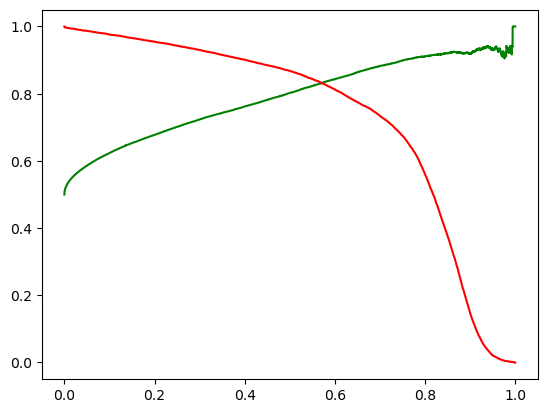

In [1080]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

#### From the above plot, we can consider 0.55 as a cutoff point probability to make predictions on test set.

### Making predictions on test data set

In [1107]:
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = logm2.predict(X_test_sm)

In [1108]:
# Converting y_pred to a dataframe which is an array
y_test_pred_1 = pd.DataFrame(y_test_pred)
y_test_pred_1.head()

,0
6587,0.926303
3080,0.132052
21632,0.089338
1366,0.270821
5341,0.001379


In [1109]:
# Converting y_test to a dataframe which is an array
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
21857,0.0
10029,0.0
72449,0.0
4463,0.0
17619,0.0


In [1110]:
y_test_df["ChurnNumber"] = y_test_df.index
y_test_df.head()

,churn,ChurnNumber
21857,0.0,21857
10029,0.0,10029
72449,0.0,72449
4463,0.0,4463
17619,0.0,17619


In [1111]:
# Removing index on both datasets to append them side by side
y_test_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [1112]:
# Appending y_test_df and y_test_pred_1
y_test_pred_final = pd.concat([y_test_df, y_test_pred_1], axis=1)
y_test_pred_final.head()

,churn,ChurnNumber,0
0,0.0,21857,0.926303
1,0.0,10029,0.132052
2,0.0,72449,0.089338
3,0.0,4463,0.270821
4,0.0,17619,0.001379


In [1113]:
y_test_pred_final.rename(columns={0:'Churn_Prob'}, inplace=True)

In [1114]:
y_test_pred_final['final_predicted'] = y_test_pred_final['Churn_Prob'].apply(lambda x:1 if x > 0.55 else 0)
y_test_pred_final.head()

,churn,ChurnNumber,Churn_Prob,final_predicted
0,0.0,21857,0.926303,1
1,0.0,10029,0.132052,0
2,0.0,72449,0.089338,0
3,0.0,4463,0.270821,0
4,0.0,17619,0.001379,0


### Metrics on test set

#### Confusion matrix

In [1115]:
confusion_test = confusion_matrix(y_test_pred_final.churn, y_test_pred_final.final_predicted)
confusion_test

array([[6766, 1503],
       [ 146,  586]], dtype=int64)

In [1124]:
# Calculate accuracy, precision, recall, f1 score for 0.55 cutoff on test set
get_metrics(y_test_pred_final.churn, y_test_pred_final, 'final_predicted')

accuracy: 0.82
precision: 0.28
recall: 0.8


#### If losing a valuable customers is extensively a high loss to the business, then they can go for 0.7 or 0.8 cutoff point. But here we have consider 0.55 as the optimal cutoff point and proceeded with test evaluation.

### Understanding important predictors

In [1137]:
imp_features = col.to_list()
imp_features

['arpu_6',
 'onnet_mou_8',
 'offnet_mou_8',
 'roam_og_mou_8',
 'loc_og_mou_8',
 'std_og_t2f_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'loc_ic_mou_8',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_8',
 'monthly_2g_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'aon',
 'aug_vbc_3g',
 'sep_vbc_3g']

<Axes: >

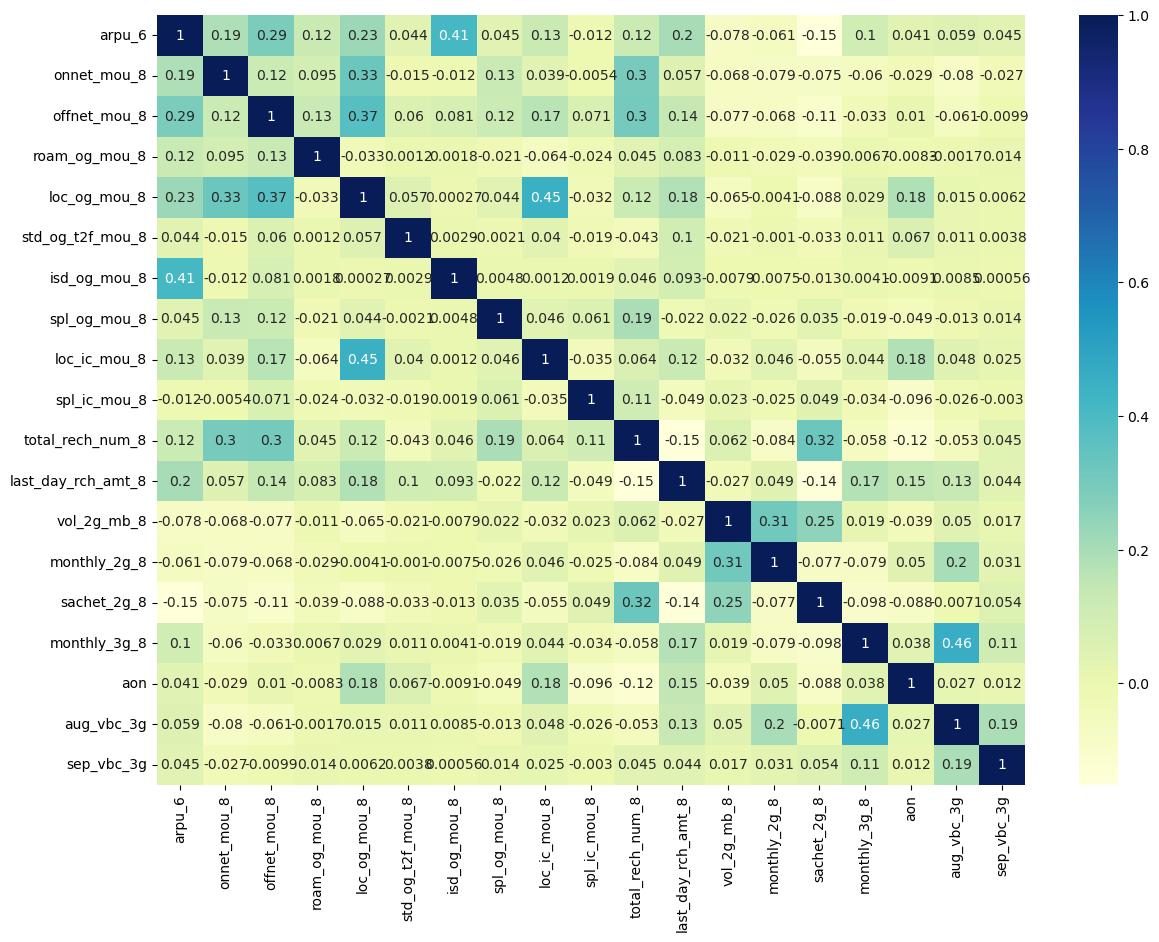

In [1138]:
# Correlation between final features
plt.figure(figsize=(14,10))
sns.heatmap(telecom_new[imp_features].corr(), cmap="YlGnBu", annot=True)

#### The above plot shows that the final predictors seems to have fairly low correlations.

#                                          Conclusion:

#### The important features to predict which customers are at high risk of churn:
'arpu_6', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g'

#### Suggestions to consider to predict the churn:
    - Local incoming and outgoing usage are some of the important features.
    - Most of the important features are from the action phase.
    - Average revenue per user also adds important feature to predict churn.
    - Customer whoes tenure is less that 4 years tends to likely churn.
    - Mothly data and usage rate during action phase also tells about the customer churn probability.
    - The usage of all kinds of calls within the same network and outside the network also plays an important aspect to predict churn.
    

#### Inferences from the models:
The main objective of this project is to predict whether the high value customers will be churned or not i.e. customer retention is more important. Hence it is important to minimise the false negative, as it can result in the loss of valuable customers and revenue for the business. This can be achieved with recall metrics. From the models we built, Logistic Regression yields a decent accuracy rate along with the highest rate of recall, followed by AdaBoost and Random Forest model metrics.